## Setup

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils
from stocksense.api import data as api_data

In [2]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [3]:
TRAIN = True

### Data

In [4]:
stock_list = ['MSFT', 'AAPL', 'AXP', 'AMGN', 'CSCO', 'HON', 'IBM', 'KO']

dfs_train = [await api_data.get_kline_df('yfinance', i, datetime(2000, 1, 1), datetime(2022, 12, 31), '1d') for i in stock_list]
assert all([i.shape == dfs_train[0].shape for i in dfs_train])

dfs_test = [await api_data.get_kline_df('yfinance', i, datetime(2023, 1, 1), datetime(2024, 12, 1), '1d') for i in stock_list]
assert all([i.shape == dfs_test[0].shape for i in dfs_test])

df_dji = await api_data.get_kline_df('yfinance', '^DJI', datetime(2023, 1, 1), datetime(2024, 12, 1), '1d')

### Environment

In [5]:
env_kwargs = {
    'trading_fees': 0.01/100,
    'windows': 5
}
env = scenv.MultiStockTradingEnv(name= "MY_ENV", dfs=dfs_train, **env_kwargs)
env_for_buy_and_hold = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_BUY_AND_HOLD", dfs=dfs_test, strategy='buy_and_hold', **env_kwargs)
env_for_dji = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_DJI", dfs=[df_dji], strategy='buy_and_hold', **env_kwargs)
env_test = scenv.MultiStockTradingEnv(name= "MY_ENV_TEST", dfs=dfs_test, **env_kwargs)

## Baseline: Random Agent

In [6]:
done, truncated = False, False
observation, info = env_test.reset()
while not done and not truncated:
    action = env_test.action_space.sample()
    observation, reward, done, truncated, info = env_test.step(action)
history_random = env_test.get_history()

Portfolio Return :  2.83%


## Baseline: Buy and Hold

In [7]:
done, truncated = False, False
observation, info = env_for_buy_and_hold.reset()
while not done and not truncated:
    action = [1/len(stock_list)] * (len(stock_list)) + [0]
    observation, reward, done, truncated, info = env_for_buy_and_hold.step(action)
history_buy_and_hold = env_for_buy_and_hold.get_history()
print(history_buy_and_hold[0], history_buy_and_hold[-1])

Portfolio Return : 32.12%
1000.0 1321.1602535287127


## Baseline: DJI

In [8]:
done, truncated = False, False
observation, info = env_for_dji.reset()
while not done and not truncated:
    action = [1, 0]
    observation, reward, done, truncated, info = env_for_dji.step(action)
history_dji = env_for_dji.get_history()

Portfolio Return : 29.87%


## Agent: DQN

In [9]:
policy_kwargs = {
    'net_arch': [128, 128]
}
hparas = {
    'batch_size': 128,
    'gamma': 0.99,
    'exploration_initial_eps': 0.9,
    'exploration_final_eps': 0.05,
    'exploration_fraction': 0.001,
    'target_update_interval': 10000,
    'learning_rate': 1e-4,
    'buffer_size': 10000,
    'policy_kwargs': policy_kwargs,
    # 'tensorboard_log': 'dqn_tensorboard'
}

In [17]:
from stable_baselines3 import DQN

if (TRAIN):
    model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 15)
    model.save("dqn")

model = DQN.load("dqn")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_dqn = env_test.get_history()

Portfolio Return : 184.51%
Portfolio Return : 2067.53%
Portfolio Return : 4280.24%
Portfolio Return : 8923.12%
Portfolio Return : 42824.31%
Portfolio Return : 6444.65%
Portfolio Return : 69614.57%
Portfolio Return : 54122.29%
Portfolio Return : 39638.21%
Portfolio Return : 204401.59%
Portfolio Return : 2067092.69%
Portfolio Return : 1389360.11%
Portfolio Return : 2722295.15%
Portfolio Return : 2370450.02%
Portfolio Return : 2813671.10%
predicting...
Portfolio Return : 34.40%


## Agent: DQN-overfitting

In [11]:
if (TRAIN):
    model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 60)
    model.save("dqn-overfitting")

model = DQN.load("dqn-overfitting")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_dqn_overfitting = env_test.get_history()

Portfolio Return : 52.49%
Portfolio Return : 7180.63%
Portfolio Return : 5631.27%
Portfolio Return : 42870.18%
Portfolio Return : 30550.98%
Portfolio Return : 312879.85%
Portfolio Return : 83218.15%
Portfolio Return : 363758.92%
Portfolio Return : 736667.01%
Portfolio Return : 1398739.82%
Portfolio Return : 43170357.74%
Portfolio Return : 21088271.75%
Portfolio Return : 88825739.95%
Portfolio Return : 161102427.96%
Portfolio Return : 681802582.24%
Portfolio Return : 219349786.73%
Portfolio Return : 2093889113.04%
Portfolio Return : 8890168551.94%
Portfolio Return : 31807143486.33%
Portfolio Return : 21845781355.07%
Portfolio Return : 8182404942.25%
Portfolio Return : 27643938598.23%
Portfolio Return : 333492617848.02%
Portfolio Return : 54145791436.27%
Portfolio Return : 35565604789.84%
Portfolio Return : 55466346723.85%
Portfolio Return : 99617098357.44%
Portfolio Return : 333047527038.06%
Portfolio Return : 316938907793.06%
Portfolio Return : 686197344046.16%
Portfolio Return : 10230

## Agent: A2C

In [12]:
from stable_baselines3 import A2C

if (TRAIN):
    model = A2C('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 15)
    model.save("a2c")

model = A2C.load("a2c", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_a2c = env_test.get_history()

Portfolio Return : 241.27%
Portfolio Return : 314.36%
Portfolio Return : 374.64%
Portfolio Return : 111.14%
Portfolio Return : 813.65%
Portfolio Return : 604.93%
Portfolio Return : 608.83%
Portfolio Return : 587.44%
Portfolio Return : 561.88%
Portfolio Return : 572.52%
Portfolio Return : 607.68%
Portfolio Return : 592.36%
Portfolio Return : 580.23%
Portfolio Return : 589.83%
Portfolio Return : 658.84%
predicting...
Portfolio Return : 26.67%


## Agent: PPO

In [14]:
from stable_baselines3 import PPO

if (TRAIN):
    model = PPO('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 15)
    model.save("ppo")

model = PPO.load("ppo", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_ppo = env_test.get_history()

Portfolio Return : 1456.47%
Portfolio Return : 269.63%
Portfolio Return : 331.79%
Portfolio Return :  3.86%
Portfolio Return : 371.40%
Portfolio Return : 177.86%
Portfolio Return : 234.70%
Portfolio Return : 252.81%
Portfolio Return : 193.16%
Portfolio Return : 79.10%
Portfolio Return : 147.48%
Portfolio Return : 862.98%
Portfolio Return : 911.43%
Portfolio Return : 110.82%
Portfolio Return : 582.03%
predicting...
Portfolio Return :  9.27%


### Visualization

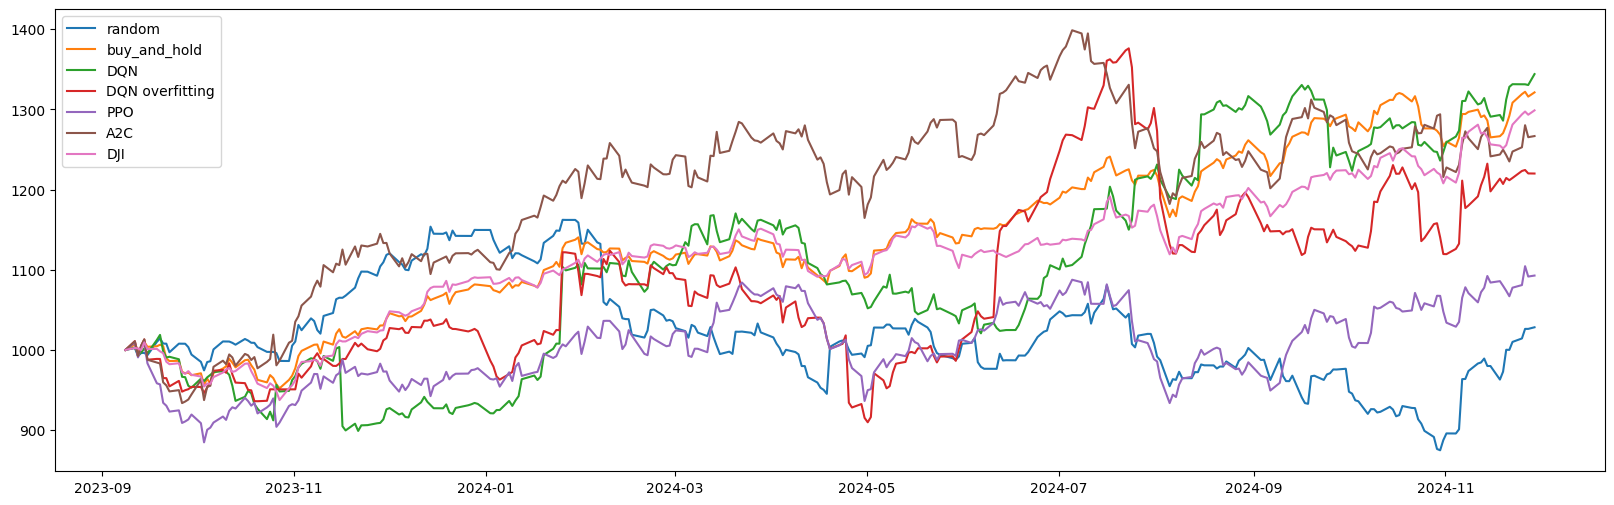

In [18]:
y_axis = [datetime.fromtimestamp(i//1000) for i in env_test.get_date()[4:]]
plt.figure(figsize=(20, 6))
plt.plot(y_axis, history_random, label="random")
plt.plot(y_axis, history_buy_and_hold, label="buy_and_hold")
plt.plot(y_axis, history_dqn, label="DQN")
plt.plot(y_axis, history_dqn_overfitting, label="DQN overfitting")
plt.plot(y_axis, history_ppo, label="PPO")
plt.plot(y_axis, history_a2c, label="A2C")
plt.plot(y_axis, history_dji, label="DJI")
plt.legend()
plt.show()

In [19]:
df_solution = pd.DataFrame()
df_solution['unix'] = env_test.get_date()[4:]
df_solution['account_value_dqn'] = history_dqn
df_solution['daily_return_dqn'] = df_solution['account_value_dqn'].pct_change(1)
df_solution['account_value_dqn_overfitting'] = history_dqn_overfitting
df_solution['daily_return_dqn_overfitting'] = df_solution['account_value_dqn_overfitting'].pct_change(1)
df_solution['account_value_a2c'] = history_a2c
df_solution['daily_return_a2c'] = df_solution['account_value_a2c'].pct_change(1)
df_solution['account_value_ppo'] = history_ppo
df_solution['daily_return_ppo'] = df_solution['account_value_ppo'].pct_change(1)
print(df_solution.head(5))
# store the solution
df_solution.to_csv('solution.csv', index=False)

                                    unix  ...  daily_return_ppo
date                                      ...                  
2023-09-08 00:00:00+00:00  1694131200000  ...               NaN
2023-09-11 00:00:00+00:00  1694390400000  ...          0.009328
2023-09-12 00:00:00+00:00  1694476800000  ...         -0.018456
2023-09-13 00:00:00+00:00  1694563200000  ...          0.012932
2023-09-14 00:00:00+00:00  1694649600000  ...          0.005258

[5 rows x 9 columns]
